use sklearn to do cross-validation

In [9]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
plt.style.use('seaborn')

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [10]:
housing = pd.read_csv('Housing.csv')

In [11]:
# data preparation

binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map({'yes': 1, "no": 0})

# applying the function to the housing variables list
housing[binary_vars_list] = housing[binary_vars_list].apply(binary_map)

status = pd.get_dummies(housing['furnishingstatus'], drop_first = True)
housing = pd.concat([housing, status], axis = 1)
housing.drop(['furnishingstatus'], axis = 1, inplace = True)

In [12]:
# train-test 70-30 split
df_train, df_test = train_test_split(housing, train_size = 0.7,test_size = 0.3,random_state = 101)

scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_test[numeric_vars]  = scaler.fit_transform(df_test[numeric_vars])

In [13]:
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

In [14]:
# running RFE with number of features=6

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)


In [19]:
# k-fold CV (using all the 13 variables)
lm     = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)

# create a KFold object with 10 splits 
folds  = KFold(n_splits = 10, shuffle = True, random_state = 101)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   

array([0.63074763, 0.80442276, 0.69120111, 0.60591266, 0.65680316,
       0.71174348, 0.5773491 , 0.59113273, 0.55782761, 0.68331716])

In [20]:
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.00872719, -0.00806276, -0.00812606, -0.00931227, -0.00967761])

In [21]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)                  

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score='raise-deprecating',
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='warn', n_jobs=None,
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=0)

In [22]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.016968,0.004258,0.001904,7.873966e-04,1,{'n_features_to_select': 1},0.243734,0.062132,0.295726,0.291097,...,0.262277,0.115519,13,0.315758,0.335521,0.302997,0.303737,0.248328,0.301268,0.028965
1,0.012170,0.001749,0.001241,3.804496e-04,2,{'n_features_to_select': 2},0.473706,0.379333,0.451141,0.457731,...,0.459913,0.050497,12,0.481133,0.493681,0.486964,0.485366,0.455708,0.480570,0.013071
2,0.009532,0.001235,0.000998,7.776979e-07,3,{'n_features_to_select': 3},0.531062,0.425201,0.512182,0.459088,...,0.512291,0.071328,11,0.546131,0.559782,0.550407,0.559558,0.502548,0.543685,0.021234
3,0.008472,0.001253,0.001011,2.737419e-05,4,{'n_features_to_select': 4},0.563873,0.471012,0.549337,0.440303,...,0.536156,0.075690,10,0.579371,0.590448,0.582733,0.615299,0.540385,0.581647,0.024161
4,0.006778,0.001215,0.000998,7.893059e-07,5,{'n_features_to_select': 5},0.545710,0.493562,0.574301,0.457919,...,0.544874,0.067326,9,0.592913,0.595886,0.627689,0.629191,0.546133,0.598362,0.030246
5,0.005617,0.000489,0.000816,4.094466e-04,6,{'n_features_to_select': 6},0.554879,0.558346,0.592999,0.504307,...,0.573071,0.049735,8,0.646636,0.639806,0.636793,0.677045,0.555439,0.631144,0.040460
6,0.005454,0.000470,0.001040,8.416399e-05,7,{'n_features_to_select': 7},0.568420,0.636244,0.657874,0.548400,...,0.623347,0.058147,7,0.692054,0.671380,0.671217,0.692107,0.600190,0.665390,0.033899
7,0.005204,0.000976,0.000798,3.988983e-04,8,{'n_features_to_select': 8},0.576702,0.633543,0.680519,0.584787,...,0.647842,0.069202,6,0.708583,0.673911,0.685679,0.703656,0.626974,0.679760,0.029180
8,0.004044,0.000043,0.001001,5.218438e-05,9,{'n_features_to_select': 9},0.588703,0.618228,0.685157,0.589356,...,0.647903,0.065574,5,0.722607,0.685280,0.686587,0.704536,0.650381,0.689878,0.023992
9,0.003923,0.000631,0.000783,3.924850e-04,10,{'n_features_to_select': 10},0.590189,0.604786,0.692866,0.604503,...,0.649578,0.064538,4,0.722925,0.700768,0.692623,0.708782,0.659910,0.697002,0.021071


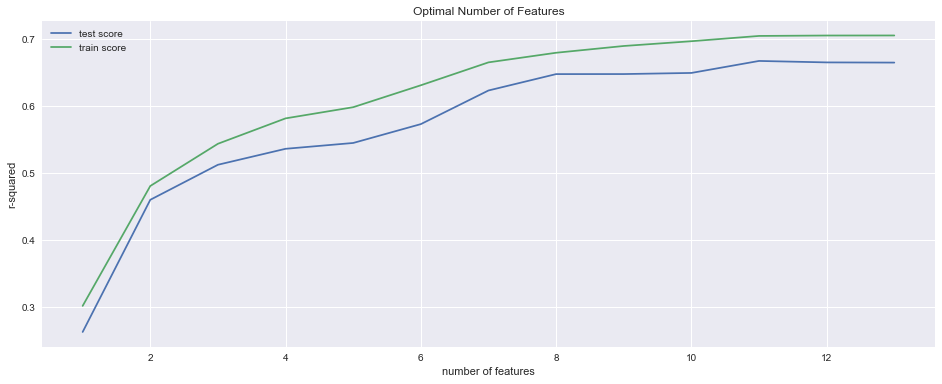

In [23]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [24]:
# final model
n_features_optimal = 11

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.590950059035266
